In [1]:
from imprint.nb_util import setup_nb

setup_nb()

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

import imprint as ip
from imprint.models.fisher_exact import FisherExact, BoschlooExact

jax.config.update("jax_enable_x64", True)

## Fisher Exact is conservative

Why?
1. Fisher exact is for discrete problems so it might not be possible to achieve precisely 5% Type I Error. 
2. Fisher exact conditions on the number of success and failures in each arm of the trial being fixed. In the parlance of 2x2 contigency tables, it conditions on both the row and column marginals. But, we only have fixed row marginals.

In [5]:
K = 4096
lam = 0.05
gs = {}
fisher_dfs = {}
boschloo_dfs = {}
for n in range(3, 15):
    print(n, end=", ")
    gs[n] = ip.cartesian_grid(
        [-3, -3], [3, 3], n=[20, 20], null_hypos=[ip.hypo("theta1 < theta0")]
    )
    fisher_dfs[n] = ip.validate(FisherExact, gs[n], lam, K=K, model_kwargs=dict(n=n))
    boschloo_dfs[n] = ip.validate(
        BoschlooExact, gs[n], lam, K=K, model_kwargs=dict(n=n)
    )
    print(
        f"n={n} max(fisher)={fisher_dfs[n]['tie_est'].max()} max(boschloo)={boschloo_dfs[n]['tie_est'].max()}"
    )

n=3 max(fisher)=0.0000 max(boschloo)=0.0159
n=4 max(fisher)=0.0034 max(boschloo)=0.0337
n=5 max(fisher)=0.0090 max(boschloo)=0.0264
n=6 max(fisher)=0.0205 max(boschloo)=0.0310
n=7 max(fisher)=0.0105 max(boschloo)=0.0374
n=8 max(fisher)=0.0107 max(boschloo)=0.0386
n=9 max(fisher)=0.0168 max(boschloo)=0.0493
n=10 max(fisher)=0.0212 max(boschloo)=0.0435
n=11 max(fisher)=0.0334 max(boschloo)=0.0471
n=12 max(fisher)=0.0364 max(boschloo)=0.0449
n=13 max(fisher)=0.0188 max(boschloo)=0.0344
n=14 max(fisher)=0.0193 max(boschloo)=0.0471


In [2]:
n = 10
alpha = 0.05
W = 0.25
g = ip.cartesian_grid(
    [-W, -W], [W, W], n=[32, 32], null_hypos=[ip.hypo("theta1 < theta0")]
)
cal_df = ip.calibrate(FisherExact, g=g, alpha=alpha, model_kwargs=dict(n=n), K=2**17)

starting 64 0 131072
starting 64 0 131072
starting 64 0 131072
starting 64 0 131072
starting 64 0 131072
starting 64 0 131072
starting 64 0 131072
starting 64 0 131072
starting 64 0 131072


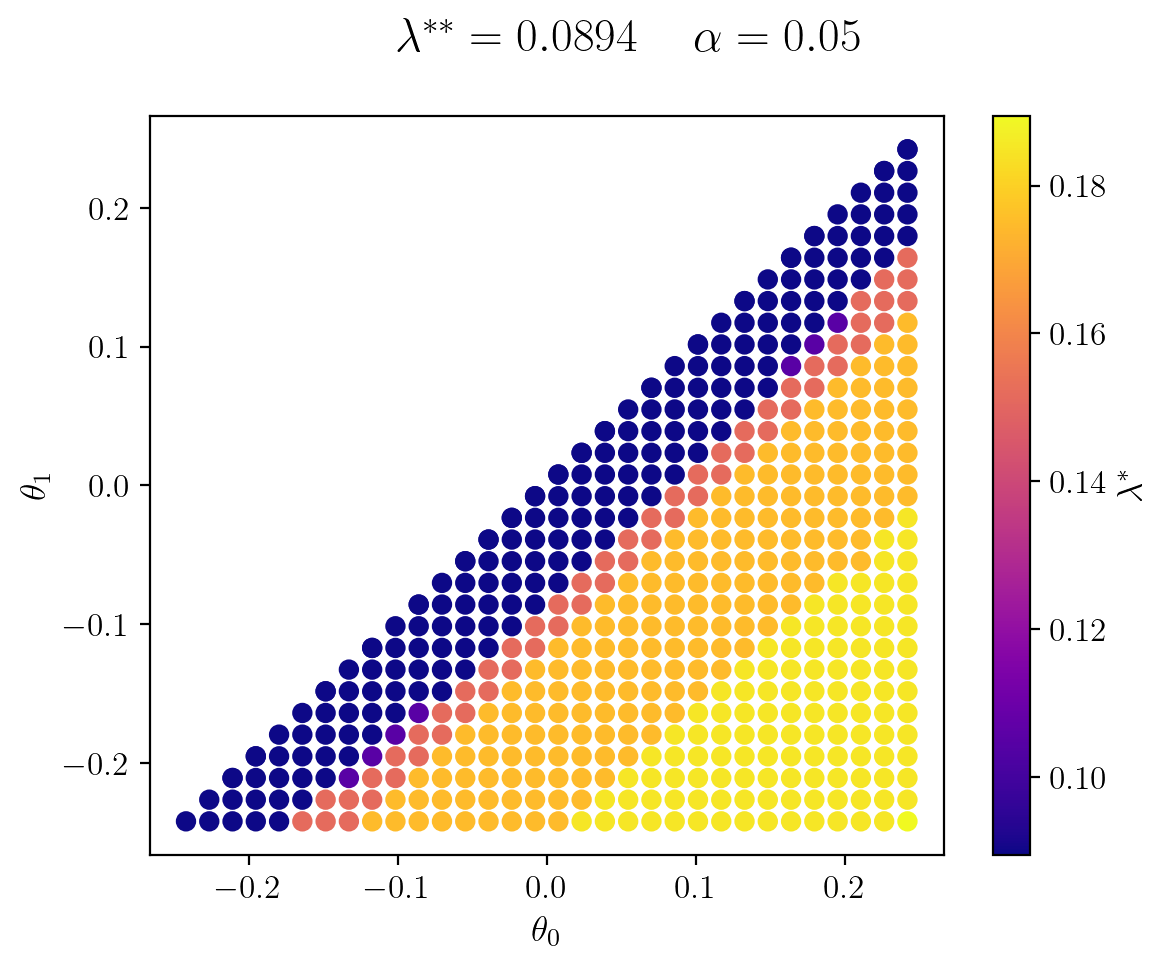

In [7]:
lamss = cal_df["lams"].min()
plt.suptitle("$\lambda^{**} = " + f"{lamss:.4f} ~~~~ \\alpha = {alpha}$")
plt.scatter(
    g.df["theta0"], g.df["theta1"], c=cal_df["lams"], s=40, vmin=lamss, vmax=lamss + 0.1
)
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.colorbar(label="$\lambda^*$")
plt.show()

In [10]:
successes = np.stack(np.meshgrid(np.arange(n + 1), np.arange(n + 1)), axis=-1).reshape(
    -1, 2
)
possible_datasets = np.concatenate(
    (successes[:, None, :], n - successes[:, None, :]),
    axis=1,
)

boschloo = np.array(
    [
        scipy.stats.boschloo_exact(possible_datasets[i], alternative="less").pvalue
        for i in range(possible_datasets.shape[0])
    ]
)
tuned_fisher = np.array(
    [
        scipy.stats.fisher_exact(possible_datasets[i], alternative="less")[1]
        for i in range(possible_datasets.shape[0])
    ]
)
differences = np.where(((boschloo < lam) != (tuned_fisher < lamss - 1e-12)))[0]
diffs = possible_datasets[differences]
b_p = boschloo[differences]
b_rej = boschloo[differences] < lam
f_p = tuned_fisher[differences]
f_rej = tuned_fisher[differences] < lamss - 1e-12
diffs, b_p, b_rej, f_p, f_rej

(array([], shape=(0, 2, 2), dtype=int64),
 array([], dtype=float64),
 array([], dtype=bool),
 array([], dtype=float64),
 array([], dtype=bool))